!pip install prophet

!pip install plotly

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [84]:
# Load epidemic data
df = pd.read_csv('../epidemic_curve.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

In [85]:
# Define cutoff date (2024-05-27)
cutoff_date = pd.to_datetime('2024-05-27')
train_df = df[df['date'] <= cutoff_date].copy()
test_df = df[(df['date'] > cutoff_date)].head(4).copy()

#### PREPARE DATA FOR PROPHET

In [86]:
'''
Prophet requires two specific column names:
    --> 'ds' (datestamp): the date column
    --> 'y' (value): the target variable
'''

prophet_train = train_df.rename(columns={'date': 'ds', 'cases': 'y'})
y_test = test_df['cases'].values

print(f"\nTraining: {len(train_df)} weeks")
print(f"Test: {len(test_df)} weeks")
print(f"Actual values: {y_test.tolist()}")


Training: 22 weeks
Test: 4 weeks
Actual values: [1829, 1577, 1203, 947]


#### Try different HYPERPARAMETERS to TEST

In [87]:
changepoint_scales = [0.05, 0.1, 0.5, 1.0]
seasonality_modes = ['additive', 'multiplicative']
add_monthly_seasonality = [True, False]
fourier_orders = [3, 5, 8, 10]


results = []

In [88]:
print("TESTING DIFFERENT CONFIGURATIONS...")

config_num = 0
for cp_scale, seas_mode, add_monthly, f_order in product(
    changepoint_scales, seasonality_modes, add_monthly_seasonality, fourier_orders):
    
    config_num += 1
    
    try:
        # Initialize model
        model = Prophet(
            yearly_seasonality=False,
            weekly_seasonality=False,
            daily_seasonality=False,
            seasonality_mode=seas_mode,
            changepoint_prior_scale=cp_scale,
            interval_width=0.8
        )
        
        # Add custom monthly seasonality if requested
        if add_monthly:
            model.add_seasonality(
                name='monthly',
                period=30.5,  # ~1 month
                fourier_order=f_order
            )
        
        # Train model
        model.fit(prophet_train)
        
        # Forecast
        future = model.make_future_dataframe(periods=4, freq='W')
        forecast = model.predict(future)
        forecast_test = forecast.tail(4)
        y_pred = forecast_test['yhat'].values
        
        # Evaluate
        eps = 1e-6  # to avoid division by zero in MAPE
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = np.mean(np.abs((y_test - y_pred) / (y_test + eps))) * 100
        r2 = r2_score(y_test, y_pred)
        
        # Store results
        results.append({
            'config': config_num,
            'changepoint_scale': cp_scale,
            'seasonality_mode': seas_mode,
            'monthly_seasonality': add_monthly,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape,
            'R2': r2,
            'forecast': y_pred,
            'fourier_order': f_order,
            'model': model
        })
        
        print(f"Config {config_num:2d} | CP={cp_scale:.2f} | Mode={seas_mode:13s} | Monthly={add_monthly} | MAPE={mape:.2f}% | R2={r2:.3f}")
        
    except Exception as e:
        print(f"Config {config_num:2d} | FAILED: {e}")


11:09:41 - cmdstanpy - INFO - Chain [1] start processing
11:09:41 - cmdstanpy - INFO - Chain [1] done processing
11:09:41 - cmdstanpy - INFO - Chain [1] start processing
11:09:41 - cmdstanpy - INFO - Chain [1] done processing
11:09:41 - cmdstanpy - INFO - Chain [1] start processing


TESTING DIFFERENT CONFIGURATIONS...
Config  1 | CP=0.05 | Mode=additive      | Monthly=True | MAPE=50.38% | R2=-3.194
Config  2 | CP=0.05 | Mode=additive      | Monthly=True | MAPE=43.96% | R2=-2.189


11:09:41 - cmdstanpy - INFO - Chain [1] done processing
11:09:41 - cmdstanpy - INFO - Chain [1] start processing


Config  3 | CP=0.05 | Mode=additive      | Monthly=True | MAPE=61.17% | R2=-4.921


11:09:44 - cmdstanpy - INFO - Chain [1] done processing
11:09:44 - cmdstanpy - INFO - Chain [1] start processing
11:09:44 - cmdstanpy - INFO - Chain [1] done processing
11:09:44 - cmdstanpy - INFO - Chain [1] start processing
11:09:44 - cmdstanpy - INFO - Chain [1] done processing
11:09:44 - cmdstanpy - INFO - Chain [1] start processing
11:09:44 - cmdstanpy - INFO - Chain [1] done processing
11:09:44 - cmdstanpy - INFO - Chain [1] start processing
11:09:44 - cmdstanpy - INFO - Chain [1] done processing


Config  4 | CP=0.05 | Mode=additive      | Monthly=True | MAPE=9.53% | R2=0.808
Config  5 | CP=0.05 | Mode=additive      | Monthly=False | MAPE=51.26% | R2=-3.255
Config  6 | CP=0.05 | Mode=additive      | Monthly=False | MAPE=51.26% | R2=-3.255
Config  7 | CP=0.05 | Mode=additive      | Monthly=False | MAPE=51.26% | R2=-3.255


11:09:44 - cmdstanpy - INFO - Chain [1] start processing
11:09:44 - cmdstanpy - INFO - Chain [1] done processing
11:09:44 - cmdstanpy - INFO - Chain [1] start processing
11:09:44 - cmdstanpy - INFO - Chain [1] done processing
11:09:44 - cmdstanpy - INFO - Chain [1] start processing


Config  8 | CP=0.05 | Mode=additive      | Monthly=False | MAPE=51.26% | R2=-3.255
Config  9 | CP=0.05 | Mode=multiplicative | Monthly=True | MAPE=60.55% | R2=-4.361
Config 10 | CP=0.05 | Mode=multiplicative | Monthly=True | MAPE=73.60% | R2=-12.348


11:09:44 - cmdstanpy - INFO - Chain [1] done processing
11:09:44 - cmdstanpy - INFO - Chain [1] start processing


Config 11 | CP=0.05 | Mode=multiplicative | Monthly=True | MAPE=224.31% | R2=-187.290


11:09:49 - cmdstanpy - INFO - Chain [1] done processing
11:09:49 - cmdstanpy - INFO - Chain [1] start processing
11:09:50 - cmdstanpy - INFO - Chain [1] done processing
11:09:50 - cmdstanpy - INFO - Chain [1] start processing
11:09:50 - cmdstanpy - INFO - Chain [1] done processing
11:09:50 - cmdstanpy - INFO - Chain [1] start processing
11:09:50 - cmdstanpy - INFO - Chain [1] done processing
11:09:50 - cmdstanpy - INFO - Chain [1] start processing
11:09:50 - cmdstanpy - INFO - Chain [1] done processing


Config 12 | CP=0.05 | Mode=multiplicative | Monthly=True | MAPE=232.72% | R2=-90.805
Config 13 | CP=0.05 | Mode=multiplicative | Monthly=False | MAPE=51.26% | R2=-3.255
Config 14 | CP=0.05 | Mode=multiplicative | Monthly=False | MAPE=51.26% | R2=-3.255
Config 15 | CP=0.05 | Mode=multiplicative | Monthly=False | MAPE=51.26% | R2=-3.255


11:09:50 - cmdstanpy - INFO - Chain [1] start processing
11:09:50 - cmdstanpy - INFO - Chain [1] done processing
11:09:50 - cmdstanpy - INFO - Chain [1] start processing
11:09:50 - cmdstanpy - INFO - Chain [1] done processing
11:09:50 - cmdstanpy - INFO - Chain [1] start processing
11:09:50 - cmdstanpy - INFO - Chain [1] done processing
11:09:50 - cmdstanpy - INFO - Chain [1] start processing


Config 16 | CP=0.05 | Mode=multiplicative | Monthly=False | MAPE=51.26% | R2=-3.255
Config 17 | CP=0.10 | Mode=additive      | Monthly=True | MAPE=50.41% | R2=-3.199
Config 18 | CP=0.10 | Mode=additive      | Monthly=True | MAPE=43.99% | R2=-2.194
Config 19 | CP=0.10 | Mode=additive      | Monthly=True | MAPE=61.23% | R2=-4.932


11:09:55 - cmdstanpy - INFO - Chain [1] done processing
11:09:55 - cmdstanpy - INFO - Chain [1] start processing
11:09:55 - cmdstanpy - INFO - Chain [1] done processing
11:09:55 - cmdstanpy - INFO - Chain [1] start processing
11:09:55 - cmdstanpy - INFO - Chain [1] done processing
11:09:55 - cmdstanpy - INFO - Chain [1] start processing
11:09:55 - cmdstanpy - INFO - Chain [1] done processing
11:09:55 - cmdstanpy - INFO - Chain [1] start processing
11:09:55 - cmdstanpy - INFO - Chain [1] done processing


Config 20 | CP=0.10 | Mode=additive      | Monthly=True | MAPE=25.67% | R2=0.039
Config 21 | CP=0.10 | Mode=additive      | Monthly=False | MAPE=51.19% | R2=-3.243
Config 22 | CP=0.10 | Mode=additive      | Monthly=False | MAPE=51.19% | R2=-3.243
Config 23 | CP=0.10 | Mode=additive      | Monthly=False | MAPE=51.19% | R2=-3.243


11:09:55 - cmdstanpy - INFO - Chain [1] start processing
11:09:55 - cmdstanpy - INFO - Chain [1] done processing
11:09:55 - cmdstanpy - INFO - Chain [1] start processing
11:09:55 - cmdstanpy - INFO - Chain [1] done processing
11:09:55 - cmdstanpy - INFO - Chain [1] start processing


Config 24 | CP=0.10 | Mode=additive      | Monthly=False | MAPE=51.19% | R2=-3.243
Config 25 | CP=0.10 | Mode=multiplicative | Monthly=True | MAPE=60.64% | R2=-4.376
Config 26 | CP=0.10 | Mode=multiplicative | Monthly=True | MAPE=57.05% | R2=-4.986


11:10:00 - cmdstanpy - INFO - Chain [1] done processing
11:10:00 - cmdstanpy - INFO - Chain [1] start processing


Config 27 | CP=0.10 | Mode=multiplicative | Monthly=True | MAPE=955.42% | R2=-1420.408


11:10:05 - cmdstanpy - INFO - Chain [1] done processing
11:10:05 - cmdstanpy - INFO - Chain [1] start processing
11:10:05 - cmdstanpy - INFO - Chain [1] done processing
11:10:05 - cmdstanpy - INFO - Chain [1] start processing
11:10:05 - cmdstanpy - INFO - Chain [1] done processing
11:10:05 - cmdstanpy - INFO - Chain [1] start processing
11:10:05 - cmdstanpy - INFO - Chain [1] done processing
11:10:05 - cmdstanpy - INFO - Chain [1] start processing


Config 28 | CP=0.10 | Mode=multiplicative | Monthly=True | MAPE=189.06% | R2=-145.574
Config 29 | CP=0.10 | Mode=multiplicative | Monthly=False | MAPE=51.19% | R2=-3.243
Config 30 | CP=0.10 | Mode=multiplicative | Monthly=False | MAPE=51.19% | R2=-3.243
Config 31 | CP=0.10 | Mode=multiplicative | Monthly=False | MAPE=51.19% | R2=-3.243


11:10:05 - cmdstanpy - INFO - Chain [1] done processing
11:10:05 - cmdstanpy - INFO - Chain [1] start processing
11:10:05 - cmdstanpy - INFO - Chain [1] done processing
11:10:05 - cmdstanpy - INFO - Chain [1] start processing


Config 32 | CP=0.10 | Mode=multiplicative | Monthly=False | MAPE=51.19% | R2=-3.243
Config 33 | CP=0.50 | Mode=additive      | Monthly=True | MAPE=100.43% | R2=-13.386


11:10:09 - cmdstanpy - INFO - Chain [1] done processing
11:10:09 - cmdstanpy - INFO - Chain [1] start processing


Config 34 | CP=0.50 | Mode=additive      | Monthly=True | MAPE=44.98% | R2=-2.384


11:10:13 - cmdstanpy - INFO - Chain [1] done processing
11:10:13 - cmdstanpy - INFO - Chain [1] start processing


Config 35 | CP=0.50 | Mode=additive      | Monthly=True | MAPE=64.41% | R2=-5.448


11:10:18 - cmdstanpy - INFO - Chain [1] done processing
11:10:18 - cmdstanpy - INFO - Chain [1] start processing
11:10:18 - cmdstanpy - INFO - Chain [1] done processing
11:10:18 - cmdstanpy - INFO - Chain [1] start processing
11:10:19 - cmdstanpy - INFO - Chain [1] done processing
11:10:19 - cmdstanpy - INFO - Chain [1] start processing
11:10:19 - cmdstanpy - INFO - Chain [1] done processing
11:10:19 - cmdstanpy - INFO - Chain [1] start processing


Config 36 | CP=0.50 | Mode=additive      | Monthly=True | MAPE=163.27% | R2=-41.880
Config 37 | CP=0.50 | Mode=additive      | Monthly=False | MAPE=97.73% | R2=-12.794
Config 38 | CP=0.50 | Mode=additive      | Monthly=False | MAPE=97.73% | R2=-12.794
Config 39 | CP=0.50 | Mode=additive      | Monthly=False | MAPE=97.73% | R2=-12.794


11:10:19 - cmdstanpy - INFO - Chain [1] done processing
11:10:19 - cmdstanpy - INFO - Chain [1] start processing


Config 40 | CP=0.50 | Mode=additive      | Monthly=False | MAPE=97.73% | R2=-12.794


11:10:22 - cmdstanpy - INFO - Chain [1] done processing
11:10:22 - cmdstanpy - INFO - Chain [1] start processing


Config 41 | CP=0.50 | Mode=multiplicative | Monthly=True | MAPE=105.83% | R2=-14.648


11:10:25 - cmdstanpy - INFO - Chain [1] done processing
11:10:26 - cmdstanpy - INFO - Chain [1] start processing


Config 42 | CP=0.50 | Mode=multiplicative | Monthly=True | MAPE=53.67% | R2=-4.048


11:10:30 - cmdstanpy - INFO - Chain [1] done processing
11:10:30 - cmdstanpy - INFO - Chain [1] start processing


Config 43 | CP=0.50 | Mode=multiplicative | Monthly=True | MAPE=240.53% | R2=-86.595


11:10:35 - cmdstanpy - INFO - Chain [1] done processing
11:10:35 - cmdstanpy - INFO - Chain [1] start processing
11:10:35 - cmdstanpy - INFO - Chain [1] done processing
11:10:35 - cmdstanpy - INFO - Chain [1] start processing
11:10:35 - cmdstanpy - INFO - Chain [1] done processing
11:10:35 - cmdstanpy - INFO - Chain [1] start processing
11:10:35 - cmdstanpy - INFO - Chain [1] done processing
11:10:35 - cmdstanpy - INFO - Chain [1] start processing


Config 44 | CP=0.50 | Mode=multiplicative | Monthly=True | MAPE=250.03% | R2=-140.618
Config 45 | CP=0.50 | Mode=multiplicative | Monthly=False | MAPE=97.73% | R2=-12.794
Config 46 | CP=0.50 | Mode=multiplicative | Monthly=False | MAPE=97.73% | R2=-12.794
Config 47 | CP=0.50 | Mode=multiplicative | Monthly=False | MAPE=97.73% | R2=-12.794


11:10:35 - cmdstanpy - INFO - Chain [1] done processing
11:10:35 - cmdstanpy - INFO - Chain [1] start processing
11:10:35 - cmdstanpy - INFO - Chain [1] done processing
11:10:35 - cmdstanpy - INFO - Chain [1] start processing


Config 48 | CP=0.50 | Mode=multiplicative | Monthly=False | MAPE=97.73% | R2=-12.794
Config 49 | CP=1.00 | Mode=additive      | Monthly=True | MAPE=96.34% | R2=-12.234


11:10:39 - cmdstanpy - INFO - Chain [1] done processing
11:10:39 - cmdstanpy - INFO - Chain [1] start processing


Config 50 | CP=1.00 | Mode=additive      | Monthly=True | MAPE=29.16% | R2=-1.459


11:10:44 - cmdstanpy - INFO - Chain [1] done processing
11:10:44 - cmdstanpy - INFO - Chain [1] start processing


Config 51 | CP=1.00 | Mode=additive      | Monthly=True | MAPE=75.19% | R2=-9.241


11:10:47 - cmdstanpy - INFO - Chain [1] done processing
11:10:47 - cmdstanpy - INFO - Chain [1] start processing
11:10:47 - cmdstanpy - INFO - Chain [1] done processing
11:10:47 - cmdstanpy - INFO - Chain [1] start processing
11:10:47 - cmdstanpy - INFO - Chain [1] done processing
11:10:47 - cmdstanpy - INFO - Chain [1] start processing


Config 52 | CP=1.00 | Mode=additive      | Monthly=True | MAPE=12.27% | R2=0.618
Config 53 | CP=1.00 | Mode=additive      | Monthly=False | MAPE=93.54% | R2=-11.671
Config 54 | CP=1.00 | Mode=additive      | Monthly=False | MAPE=93.54% | R2=-11.671


11:10:47 - cmdstanpy - INFO - Chain [1] done processing
11:10:47 - cmdstanpy - INFO - Chain [1] start processing
11:10:47 - cmdstanpy - INFO - Chain [1] done processing
11:10:47 - cmdstanpy - INFO - Chain [1] start processing


Config 55 | CP=1.00 | Mode=additive      | Monthly=False | MAPE=93.54% | R2=-11.671
Config 56 | CP=1.00 | Mode=additive      | Monthly=False | MAPE=93.54% | R2=-11.671


11:10:50 - cmdstanpy - INFO - Chain [1] done processing
11:10:50 - cmdstanpy - INFO - Chain [1] start processing


Config 57 | CP=1.00 | Mode=multiplicative | Monthly=True | MAPE=121.67% | R2=-20.774


11:10:54 - cmdstanpy - INFO - Chain [1] done processing
11:10:54 - cmdstanpy - INFO - Chain [1] start processing


Config 58 | CP=1.00 | Mode=multiplicative | Monthly=True | MAPE=293.75% | R2=-141.339


11:10:58 - cmdstanpy - INFO - Chain [1] done processing
11:10:58 - cmdstanpy - INFO - Chain [1] start processing


Config 59 | CP=1.00 | Mode=multiplicative | Monthly=True | MAPE=189.29% | R2=-103.182


11:11:04 - cmdstanpy - INFO - Chain [1] done processing
11:11:04 - cmdstanpy - INFO - Chain [1] start processing
11:11:04 - cmdstanpy - INFO - Chain [1] done processing
11:11:04 - cmdstanpy - INFO - Chain [1] start processing
11:11:04 - cmdstanpy - INFO - Chain [1] done processing
11:11:04 - cmdstanpy - INFO - Chain [1] start processing


Config 60 | CP=1.00 | Mode=multiplicative | Monthly=True | MAPE=675.74% | R2=-718.770
Config 61 | CP=1.00 | Mode=multiplicative | Monthly=False | MAPE=93.54% | R2=-11.671
Config 62 | CP=1.00 | Mode=multiplicative | Monthly=False | MAPE=93.54% | R2=-11.671


11:11:04 - cmdstanpy - INFO - Chain [1] done processing
11:11:04 - cmdstanpy - INFO - Chain [1] start processing
11:11:04 - cmdstanpy - INFO - Chain [1] done processing


Config 63 | CP=1.00 | Mode=multiplicative | Monthly=False | MAPE=93.54% | R2=-11.671
Config 64 | CP=1.00 | Mode=multiplicative | Monthly=False | MAPE=93.54% | R2=-11.671


#### BEST CONFIGURATION

In [89]:
results_df = pd.DataFrame(results)
best_by_mape = results_df.sort_values('MAPE').head(5)

print(results_df[['config', 'changepoint_scale', 'seasonality_mode', 'fourier_order',
                   'monthly_seasonality', 'MAE', 'RMSE', 'MAPE', 'R2']].head(5).to_string(index=False))

# Get best model
best_config = results_df.iloc[0]
best_model = best_config['model']
best_forecast = best_config['forecast']

#print(f"Changepoint Scale: {best_config['changepoint_scale']}")
#print(f"Seasonality Mode: {best_config['seasonality_mode']}")
#print(f"Monthly Seasonality: {best_config['monthly_seasonality']}")
print(f"Forecasted: {best_forecast.round().astype(int).tolist()}")
print(f"Actual:     {y_test.tolist()}")

 config  changepoint_scale seasonality_mode  fourier_order  monthly_seasonality        MAE       RMSE      MAPE        R2
      1               0.05         additive              3                 True 549.687479 693.635855 50.377096 -3.193737
      2               0.05         additive              5                 True 480.344517 604.905335 43.957497 -2.189429
      3               0.05         additive              8                 True 678.016939 824.168895 61.174740 -4.920666
      4               0.05         additive             10                 True 111.256389 148.497746  9.531854  0.807789
      5               0.05         additive              3                False 563.127263 698.691784 51.255042 -3.255097
Forecasted: [1838, 1891, 1957, 2068]
Actual:     [1829, 1577, 1203, 947]


In [90]:
BEST_SEASONALITY_MODE='additive' #seasonality_mode
BEST_CP_SCALE=0.05 #changepoint_scale
BEST_FOURIER_ORDER=10 #fourier_order
ADD_MONTHLY=True #monthly_seasonality

#### INITIALIZE AND TRAIN PROPHET MODEL WITH BEST CONFIGURATION

In [91]:
model = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode=BEST_SEASONALITY_MODE,
    interval_width=0.8,
    changepoint_prior_scale=BEST_CP_SCALE
)
if ADD_MONTHLY:
    model.add_seasonality(
        name='monthly',
        period=30.5,
        fourier_order=BEST_FOURIER_ORDER
    )

In [92]:
print("Training Prophet model...")
model.fit(prophet_train)
print("Model trained successfully!")

11:11:04 - cmdstanpy - INFO - Chain [1] start processing


Training Prophet model...


11:11:06 - cmdstanpy - INFO - Chain [1] done processing


Model trained successfully!


#### MAKE FORECAST

In [93]:
# Create future dataframe (includes training + 4 new weeks)
future = model.make_future_dataframe(periods=4, freq='W')

# Generate forecast
forecast = model.predict(future)

# Extract forecast for test period only
forecast_test = forecast.tail(4)

# Get predictions
y_pred = forecast_test['yhat'].values           # Point forecast
y_pred_lower = forecast_test['yhat_lower'].values  # Lower bound
y_pred_upper = forecast_test['yhat_upper'].values  # Upper bound

#### EVALUATE ACCURACY

In [94]:
y_test = test_df['cases'].values

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Calculate prediction interval coverage
coverage = np.sum((y_test >= y_pred_lower) & (y_test <= y_pred_upper)) / len(y_test) * 100

print("RESULTS - Prophet Forecast")
print(f"Forecasted: {y_pred.round().astype(int).tolist()}")
print(f"Actual:     {y_test.tolist()}")
print(f"\nAccuracy Metrics:")
print(f"  MAE:      {mae:.2f} cases")
print(f"  RMSE:     {rmse:.2f} cases")
print(f"  MAPE:     {mape:.2f}%")
print(f"  Coverage: {coverage:.1f}% (actual within prediction interval)")

RESULTS - Prophet Forecast
Forecasted: [1975, 1552, 1185, 690]
Actual:     [1829, 1577, 1203, 947]

Accuracy Metrics:
  MAE:      111.26 cases
  RMSE:     148.50 cases
  MAPE:     9.53%
  Coverage: 75.0% (actual within prediction interval)


#### VISUALIZE FORECAST

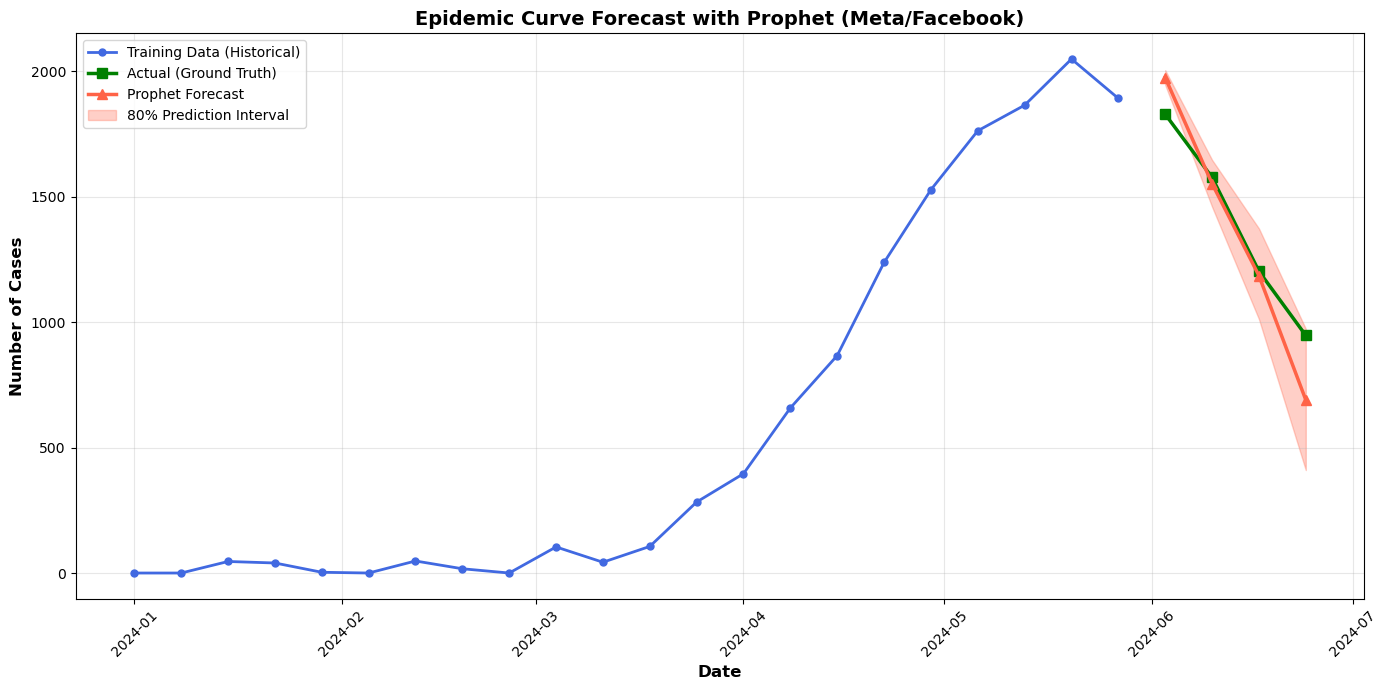

In [ ]:
plt.figure(figsize=(14, 7))
# Plot training data
plt.plot(train_df['date'], train_df['cases'], 
         'o-', label='Training Data (Historical)', 
         color='royalblue', linewidth=2, markersize=5)

# Plot actual test data
plt.plot(test_df['date'], y_test, 
         's-', label='Actual (Ground Truth)', 
         color='green', linewidth=2.5, markersize=7)

# Plot forecast
plt.plot(test_df['date'], y_pred, 
         '^-', label='Prophet Forecast', 
         color='tomato', linewidth=2.5, markersize=7)

# Plot prediction interval
plt.fill_between(test_df['date'], y_pred_lower, y_pred_upper, 
                 alpha=0.3, color='tomato', 
                 label='80% Prediction Interval')

# Formatting
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Number of Cases', fontsize=12, fontweight='bold')
plt.title('Epidemic Curve Forecast with Prophet', 
          fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()